In [1]:
!pip install -q tensorflow==2.1.0

     |████████████████████████████████| 421.8MB 25kB/s 
     |████████████████████████████████| 3.9MB 43.7MB/s 
     |████████████████████████████████| 450kB 50.1MB/s 
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.


In [2]:
!pip install -q tensorflow-quantum

     |████████████████████████████████| 3.9MB 7.4MB/s 
     |████████████████████████████████| 1.4MB 52.1MB/s 
     |████████████████████████████████| 5.3MB 22.5MB/s 
     |████████████████████████████████| 163kB 56.7MB/s 
     |████████████████████████████████| 1.2MB 50.5MB/s 
     |████████████████████████████████| 71kB 10.6MB/s 
     |████████████████████████████████| 112kB 50.9MB/s 


In [0]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [0]:
qubit = cirq.GridQubit(0, 0)

circuit1 = cirq.Circuit(cirq.X(qubit))
circuit2 = cirq.Circuit(cirq.H(qubit))

input_circuit_tensor = tfq.convert_to_tensor([circuit1, circuit2])

y_circuit = cirq.Circuit(cirq.Y(qubit))

y_appender = tfq.layers.AddCircuit()

output_circuit_tensor = y_appender(input_circuit_tensor, append=y_circuit)

In [5]:
print(tfq.from_tensor(input_circuit_tensor))

[cirq.Circuit([
    cirq.Moment(
        cirq.X(cirq.GridQubit(0, 0)),
    ),
])
 cirq.Circuit([
    cirq.Moment(
        cirq.H(cirq.GridQubit(0, 0)),
    ),
])]


In [6]:
print(tfq.from_tensor(output_circuit_tensor))

[cirq.Circuit([
    cirq.Moment(
        cirq.X(cirq.GridQubit(0, 0)),
    ),
    cirq.Moment(
        cirq.Y(cirq.GridQubit(0, 0)),
    ),
])
 cirq.Circuit([
    cirq.Moment(
        cirq.H(cirq.GridQubit(0, 0)),
    ),
    cirq.Moment(
        cirq.Y(cirq.GridQubit(0, 0)),
    ),
])]


In [0]:
def generate_data(qubits):
    n_rounds = 20  
    excitations = []
    labels = []
    for n in range(n_rounds):
        for bit in qubits:
            rng = np.random.uniform(-np.pi, np.pi)
            excitations.append(cirq.Circuit(cirq.rx(rng)(bit)))
            labels.append(1 if (-np.pi / 2) <= rng <= (np.pi / 2) else -1)

    split_ind = int(len(excitations) * 0.7)
    train_excitations = excitations[:split_ind]
    test_excitations = excitations[split_ind:]

    train_labels = labels[:split_ind]
    test_labels = labels[split_ind:]

    return tfq.convert_to_tensor(train_excitations), np.array(train_labels), \
        tfq.convert_to_tensor(test_excitations), np.array(test_labels)

In [8]:
sample_points, sample_labels, _, __ = generate_data(cirq.GridQubit.rect(1, 4))
print('Input:', tfq.from_tensor(sample_points)[0], 'Output:', sample_labels[0])
print('Input:', tfq.from_tensor(sample_points)[1], 'Output:', sample_labels[1])

Input: (0, 0): ───Rx(0.776π)─── Output: -1
Input: (0, 1): ───Rx(-0.555π)─── Output: -1


In [0]:
def cluster_state_circuit(bits):
    circuit = cirq.Circuit()
    circuit.append(cirq.H.on_each(bits))
    for this_bit, next_bit in zip(bits, bits[1:] + [bits[0]]):
        circuit.append(cirq.CZ(this_bit, next_bit))
    return circuit

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


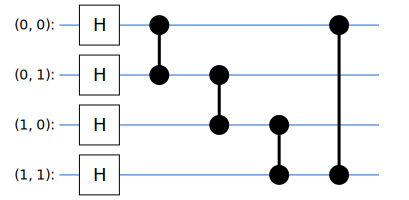

In [10]:
SVGCircuit(cluster_state_circuit(cirq.GridQubit.rect(2, 2)))

In [0]:
def one_qubit_unitary(bit, symbols):
    return cirq.Circuit(
        cirq.X(bit)**symbols[0],
        cirq.Y(bit)**symbols[1],
        cirq.Z(bit)**symbols[2])


def two_qubit_unitary(bits, symbols):
    circuit = cirq.Circuit()
    circuit += one_qubit_unitary(bits[0], symbols[0:3])
    circuit += one_qubit_unitary(bits[1], symbols[3:6])
    circuit += [cirq.ZZ(*bits)**symbols[6]]
    circuit += [cirq.YY(*bits)**symbols[7]]
    circuit += [cirq.XX(*bits)**symbols[8]]
    circuit += one_qubit_unitary(bits[0], symbols[9:12])
    circuit += one_qubit_unitary(bits[1], symbols[12:])
    return circuit


def two_qubit_pool(source_qubit, sink_qubit, symbols):
    pool_circuit = cirq.Circuit()
    sink_basis_selector = one_qubit_unitary(sink_qubit, symbols[0:3])
    source_basis_selector = one_qubit_unitary(source_qubit, symbols[3:6])
    pool_circuit.append(sink_basis_selector)
    pool_circuit.append(source_basis_selector)
    pool_circuit.append(cirq.CNOT(control=source_qubit, target=sink_qubit))
    pool_circuit.append(sink_basis_selector**-1)
    return pool_circuit

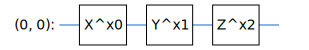

In [12]:
SVGCircuit(one_qubit_unitary(cirq.GridQubit(0, 0), sympy.symbols('x0:3')))

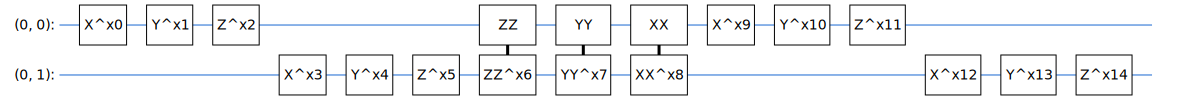

In [13]:
SVGCircuit(two_qubit_unitary(cirq.GridQubit.rect(1, 2), sympy.symbols('x0:15')))

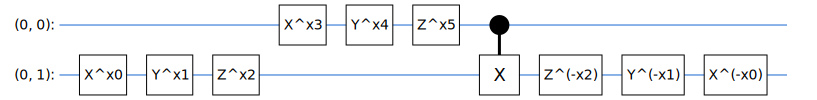

In [14]:
SVGCircuit(two_qubit_pool(*cirq.GridQubit.rect(1, 2), sympy.symbols('x0:6')))

In [0]:
def quantum_conv_circuit(bits, symbols):
    circuit = cirq.Circuit()
    for first, second in zip(bits[0::2], bits[1::2]):
        circuit += two_qubit_unitary([first, second], symbols)
    for first, second in zip(bits[1::2], bits[2::2] + [bits[0]]):
        circuit += two_qubit_unitary([first, second], symbols)
    return circuit

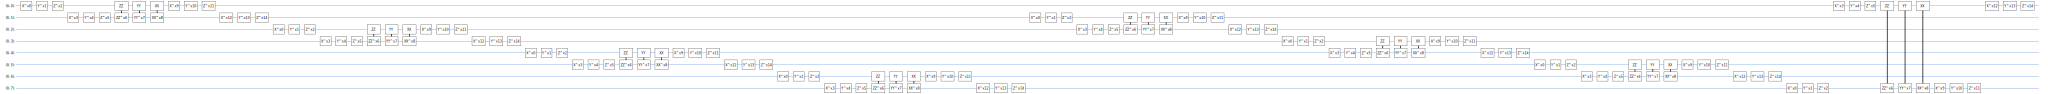

In [16]:
SVGCircuit(
    quantum_conv_circuit(cirq.GridQubit.rect(1, 8), sympy.symbols('x0:15')))

In [0]:
def quantum_pool_circuit(source_bits, sink_bits, symbols):
    circuit = cirq.Circuit()
    for source, sink in zip(source_bits, sink_bits):
        circuit += two_qubit_pool(source, sink, symbols)
    return circuit

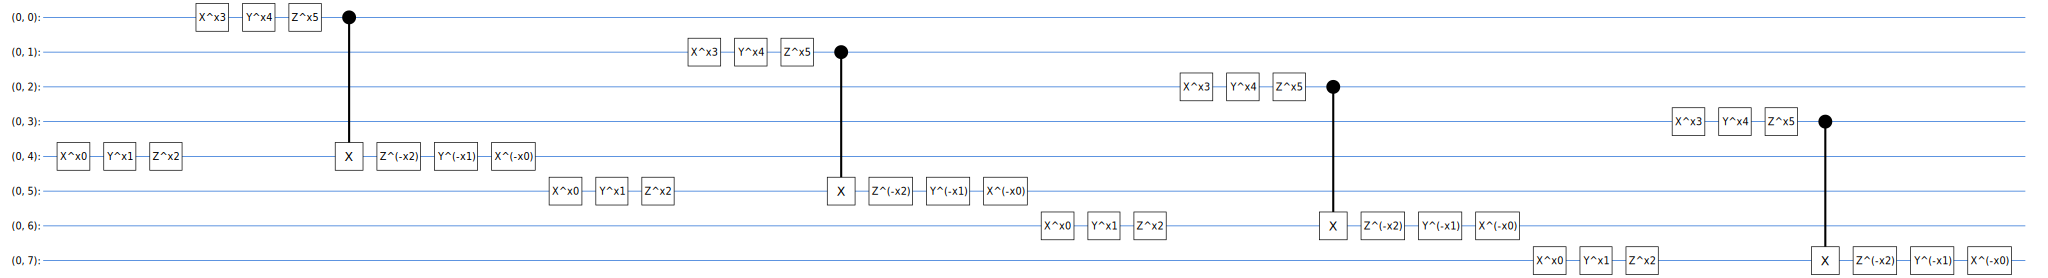

In [18]:
test_bits = cirq.GridQubit.rect(1, 8)

SVGCircuit(
    quantum_pool_circuit(test_bits[:4], test_bits[4:], sympy.symbols('x0:6')))

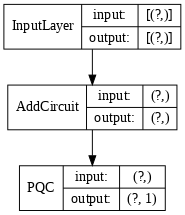

In [19]:
def create_model_circuit(qubits):
    model_circuit = cirq.Circuit()
    symbols = sympy.symbols('qconv0:63')

    model_circuit += quantum_conv_circuit(qubits, symbols[0:15])
    model_circuit += quantum_pool_circuit(qubits[:4], qubits[4:],
                                          symbols[15:21])
    model_circuit += quantum_conv_circuit(qubits[4:], symbols[21:36])
    model_circuit += quantum_pool_circuit(qubits[4:6], qubits[6:],
                                          symbols[36:42])
    model_circuit += quantum_conv_circuit(qubits[6:], symbols[42:57])
    model_circuit += quantum_pool_circuit([qubits[6]], [qubits[7]],symbols[57:63])
    return model_circuit

cluster_state_bits = cirq.GridQubit.rect(1, 8)
readout_operators = cirq.Z(cluster_state_bits[-1])

excitation_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
cluster_state = tfq.layers.AddCircuit()(
    excitation_input, prepend=cluster_state_circuit(cluster_state_bits))

quantum_model = tfq.layers.PQC(create_model_circuit(cluster_state_bits),
                               readout_operators)(cluster_state)

qcnn_model = tf.keras.Model(inputs=[excitation_input], outputs=[quantum_model])

tf.keras.utils.plot_model(qcnn_model,
                          show_shapes=True,
                          show_layer_names=False,
                          dpi=70)

In [20]:
qubits=cirq.GridQubit.rect(1, 8)
circuit=create_model_circuit(qubits)
SVGCircuit(circuit)

In [21]:
train_excitations, train_labels, test_excitations, test_labels = generate_data(
    cluster_state_bits)

@tf.function
def custom_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true)
    y_pred = tf.map_fn(lambda x: 1.0 if x >= 0 else -1.0, y_pred)
    return tf.keras.backend.mean(tf.keras.backend.equal(y_true, y_pred))


qcnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
                   loss=tf.losses.mse,
                   metrics=[custom_accuracy])

print(qcnn_model.summary())

history = qcnn_model.fit(x=train_excitations,
                         y=train_labels,
                         batch_size=16,
                         epochs=25,
                         verbose=1,
                         validation_data=(test_excitations, test_labels))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
add_circuit_1 (AddCircuit)   (None,)                   0         
_________________________________________________________________
pqc (PQC)                    (None, 1)                 63        
Total params: 63
Trainable params: 63
Non-trainable params: 0
_________________________________________________________________
None
Train on 112 samples, validate on 48 samples
Epoch 1/25
112/112 [==============================] - 14s 122ms/sample - loss: 0.8081 - custom_accuracy: 0.7679 - val_loss: 0.6740 - val_custom_accuracy: 0.8125
Epoch 2/25
112/112 [==============================] - 12s 107ms/sample - loss: 0.6420 - custom_accuracy: 0.8571 - val_loss: 0.4852 - val_custom_accuracy: 0.9583
Epoch 3/25
112/112 [===

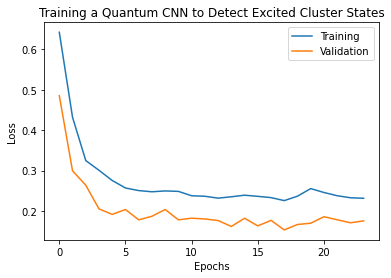

In [22]:
plt.plot(history.history['loss'][1:], label='Training')
plt.plot(history.history['val_loss'][1:], label='Validation')
plt.title('Training a Quantum CNN to Detect Excited Cluster States')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
readouts = [cirq.Z(bit) for bit in cluster_state_bits[4:]]


def multi_readout_model_circuit(qubits):
    model_circuit = cirq.Circuit()
    symbols = sympy.symbols('qconv0:21')
    model_circuit += quantum_conv_circuit(qubits, symbols[0:15])
    model_circuit += quantum_pool_circuit(qubits[:4], qubits[4:],
                                          symbols[15:21])
    return model_circuit

excitation_input_dual = tf.keras.Input(shape=(), dtype=tf.dtypes.string)

cluster_state_dual = tfq.layers.AddCircuit()(
    excitation_input_dual, prepend=cluster_state_circuit(cluster_state_bits))

quantum_model_dual = tfq.layers.PQC(
    multi_readout_model_circuit(cluster_state_bits),
    readouts)(cluster_state_dual)

d1_dual = tf.keras.layers.Dense(8)(quantum_model_dual)

d2_dual = tf.keras.layers.Dense(1)(d1_dual)

hybrid_model = tf.keras.Model(inputs=[excitation_input_dual], outputs=[d2_dual])

tf.keras.utils.plot_model(hybrid_model,
                          show_shapes=True,
                          show_layer_names=False,
                          dpi=70)

print(hybrid_model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
add_circuit_3 (AddCircuit)   (None,)                   0         
_________________________________________________________________
pqc_1 (PQC)                  (None, 4)                 21        
_________________________________________________________________
dense (Dense)                (None, 8)                 40        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 70
Trainable params: 70
Non-trainable params: 0
_________________________________________________________________
None


In [24]:
hybrid_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
                     loss=tf.losses.mse,
                     metrics=[custom_accuracy])

hybrid_history = hybrid_model.fit(x=train_excitations,
                                  y=train_labels,
                                  batch_size=16,
                                  epochs=25,
                                  verbose=1,
                                  validation_data=(test_excitations,
                                                   test_labels))

Train on 112 samples, validate on 48 samples
Epoch 1/25
112/112 [==============================] - 4s 33ms/sample - loss: 0.9839 - custom_accuracy: 0.6250 - val_loss: 0.8298 - val_custom_accuracy: 0.7292
Epoch 2/25
112/112 [==============================] - 3s 27ms/sample - loss: 0.6308 - custom_accuracy: 0.8482 - val_loss: 0.2658 - val_custom_accuracy: 0.9167
Epoch 3/25
112/112 [==============================] - 3s 27ms/sample - loss: 0.2917 - custom_accuracy: 0.9286 - val_loss: 0.1455 - val_custom_accuracy: 1.0000
Epoch 4/25
112/112 [==============================] - 3s 27ms/sample - loss: 0.2688 - custom_accuracy: 0.9375 - val_loss: 0.1345 - val_custom_accuracy: 0.9792
Epoch 5/25
112/112 [==============================] - 3s 27ms/sample - loss: 0.1984 - custom_accuracy: 0.9911 - val_loss: 0.1688 - val_custom_accuracy: 0.9167
Epoch 6/25
112/112 [==============================] - 3s 27ms/sample - loss: 0.1901 - custom_accuracy: 0.9821 - val_loss: 0.1887 - val_custom_accuracy: 0.9167
E

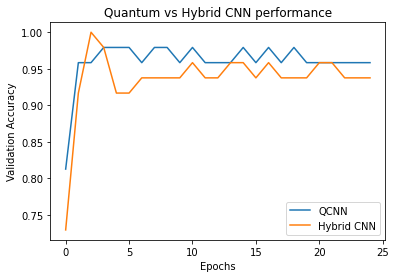

In [25]:
plt.plot(history.history['val_custom_accuracy'], label='QCNN')
plt.plot(hybrid_history.history['val_custom_accuracy'], label='Hybrid CNN')
plt.title('Quantum vs Hybrid CNN performance')
plt.xlabel('Epochs')
plt.legend()
plt.ylabel('Validation Accuracy')
plt.show()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
add_circuit_5 (AddCircuit)      (None,)              0           input_3[0][0]                    
__________________________________________________________________________________________________
pqc_2 (PQC)                     (None, 4)            21          add_circuit_5[0][0]              
__________________________________________________________________________________________________
pqc_3 (PQC)                     (None, 4)            21          add_circuit_5[0][0]              
____________________________________________________________________________________________

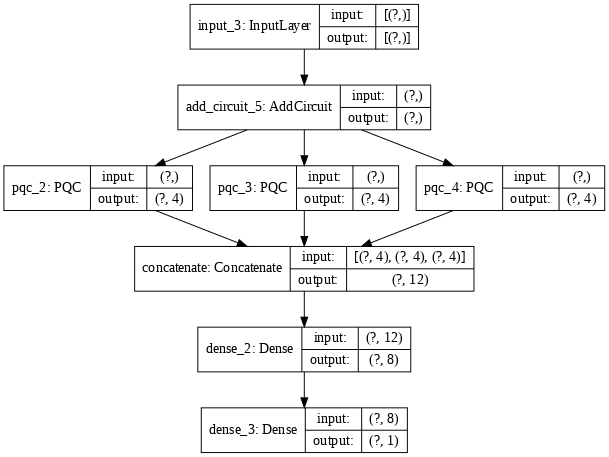

In [26]:
excitation_input_multi = tf.keras.Input(shape=(), dtype=tf.dtypes.string)

cluster_state_multi = tfq.layers.AddCircuit()(
    excitation_input_multi, prepend=cluster_state_circuit(cluster_state_bits))

quantum_model_multi1 = tfq.layers.PQC(
    multi_readout_model_circuit(cluster_state_bits),
    readouts)(cluster_state_multi)

quantum_model_multi2 = tfq.layers.PQC(
    multi_readout_model_circuit(cluster_state_bits),
    readouts)(cluster_state_multi)

quantum_model_multi3 = tfq.layers.PQC(
    multi_readout_model_circuit(cluster_state_bits),
    readouts)(cluster_state_multi)

concat_out = tf.keras.layers.concatenate(
    [quantum_model_multi1, quantum_model_multi2, quantum_model_multi3])

dense_1 = tf.keras.layers.Dense(8)(concat_out)

dense_2 = tf.keras.layers.Dense(1)(dense_1)

multi_qconv_model = tf.keras.Model(inputs=[excitation_input_multi],
                                   outputs=[dense_2])


print(multi_qconv_model.summary())

tf.keras.utils.plot_model(multi_qconv_model,
                          show_shapes=True,
                          show_layer_names=True,
                          dpi=70)

In [27]:
multi_qconv_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
    loss=tf.losses.mse,
    metrics=[custom_accuracy])

multi_qconv_history = multi_qconv_model.fit(x=train_excitations,
                                            y=train_labels,
                                            batch_size=16,
                                            epochs=25,
                                            verbose=1,
                                            validation_data=(test_excitations,
                                                             test_labels))

Train on 112 samples, validate on 48 samples
Epoch 1/25
112/112 [==============================] - 10s 87ms/sample - loss: 0.8779 - custom_accuracy: 0.6607 - val_loss: 0.6803 - val_custom_accuracy: 0.8750
Epoch 2/25
112/112 [==============================] - 8s 75ms/sample - loss: 0.4085 - custom_accuracy: 0.9643 - val_loss: 0.1875 - val_custom_accuracy: 0.9792
Epoch 3/25
112/112 [==============================] - 8s 74ms/sample - loss: 0.2093 - custom_accuracy: 0.9732 - val_loss: 0.1802 - val_custom_accuracy: 0.9792
Epoch 4/25
112/112 [==============================] - 8s 74ms/sample - loss: 0.2049 - custom_accuracy: 0.9911 - val_loss: 0.2013 - val_custom_accuracy: 0.9583
Epoch 5/25
112/112 [==============================] - 8s 74ms/sample - loss: 0.2051 - custom_accuracy: 0.9911 - val_loss: 0.1729 - val_custom_accuracy: 0.9375
Epoch 6/25
112/112 [==============================] - 8s 75ms/sample - loss: 0.1771 - custom_accuracy: 0.9911 - val_loss: 0.1773 - val_custom_accuracy: 0.9583


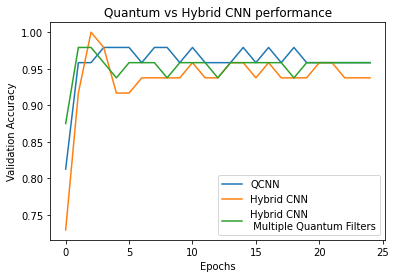

In [28]:
plt.plot(history.history['val_custom_accuracy'][:25], label='QCNN')
plt.plot(hybrid_history.history['val_custom_accuracy'][:25], label='Hybrid CNN')
plt.plot(multi_qconv_history.history['val_custom_accuracy'][:25],
         label='Hybrid CNN \n Multiple Quantum Filters')
plt.title('Quantum vs Hybrid CNN performance')
plt.xlabel('Epochs')
plt.legend()
plt.ylabel('Validation Accuracy')
plt.show()